In [1]:
import tensorflow as tf
import zipfile
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 42
np.random.seed = SEED

UNZIP_PATH = '../input/'
TRAIN_PATH = './train/'
TEST_PATH = './test/'

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
with zipfile.ZipFile(UNZIP_PATH + 'stage1_train.zip', 'r') as zip_ref:
    zip_ref.extractall('./train')
    
with zipfile.ZipFile(UNZIP_PATH + 'stage1_test.zip', 'r') as zip_ref:
    zip_ref.extractall('./test')

In [ ]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [ ]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = bool)

In [ ]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):  
    path = TRAIN_PATH + id_  
    
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  
    
    X_train[n] = img 

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)  
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:  
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask

100%|██████████| 670/670 [08:15<00:00,  1.35it/s]


In [ ]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

sizes_test = []

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    
    sizes_test.append([img.shape[0], img.shape[1]])
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    X_test[n] = img

100%|██████████| 65/65 [00:01<00:00, 43.71it/s]


In [ ]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), 
                               activation="relu", 
                               kernel_initializer="he_normal", 
                               padding="same")(inputs)
    
    x = tf.keras.layers.Dropout(0.1)(x)
    
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), 
                               activation="relu", 
                               kernel_initializer="he_normal", 
                               padding="same")(x)
    return x

def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, 
                                         (2, 2), 
                                         strides=(2, 2), 
                                         padding="same")(inputs)
    
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv

In [ ]:
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) 

c1 = conv_block(s, 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

c6 = upsample_block(c5, c4, 128)
c7 = upsample_block(c6, c3, 64)
c8 = upsample_block(c7, c2, 32)
c9 = upsample_block(c8, c1, 16)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='softmax')(c9)

In [ ]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.keras', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
            ]

In [14]:
results = model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.1, 
    batch_size = 16, 
    epochs = 25, 
    callbacks = callbacks)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.6755 - loss: 0.6718 - val_accuracy: 0.7749 - val_loss: 0.5096
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.7575 - loss: 0.4664 - val_accuracy: 0.8683 - val_loss: 0.3049
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - accuracy: 0.8537 - loss: 0.3571 - val_accuracy: 0.9231 - val_loss: 0.1885
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.9157 - loss: 0.2124 - val_accuracy: 0.9420 - val_loss: 0.1420
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.9380 - loss: 0.1628 - val_accuracy: 0.9503 - val_loss: 0.1241
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step - accuracy: 0.9468 - loss: 0.1385 - val_accuracy: 0.9496 - val_loss: 0.1230
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - accuracy: 0.9499 - loss: 0.1327 - val_accuracy: 0.9559 - val_loss: 0.1102
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.9506 - loss: 0.1304 - val_accuracy:

In [ ]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 


In [ ]:
def display_images(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Input Image:


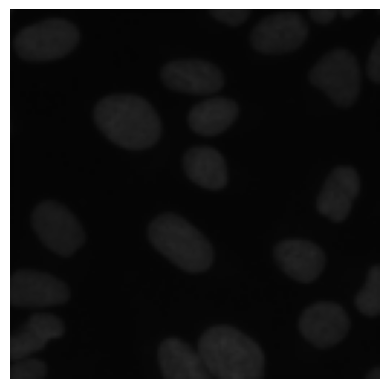

Ground Truth Mask:


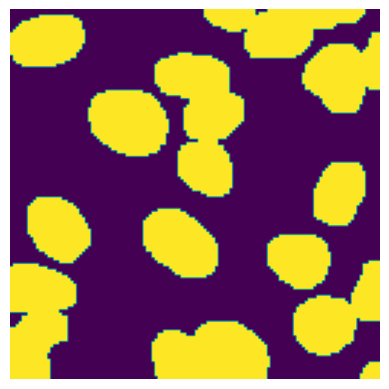

Predicted Mask:


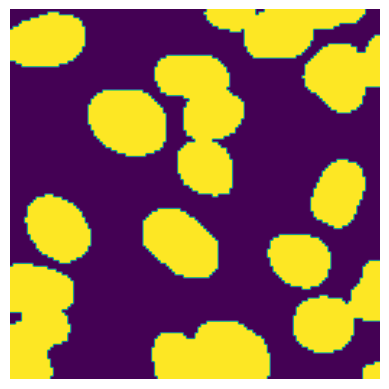

In [ ]:
ix = random.randint(0, len(preds_train_t))

print("Input Image:")
display_images(X_train[ix])

print("Ground Truth Mask:")
display_images(np.squeeze(Y_train[ix]))

print("Predicted Mask:")
display_images(np.squeeze(preds_train_t[ix]))

Validation Input Image:


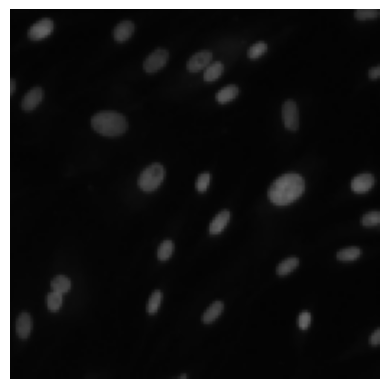

Validation Ground Truth Mask:


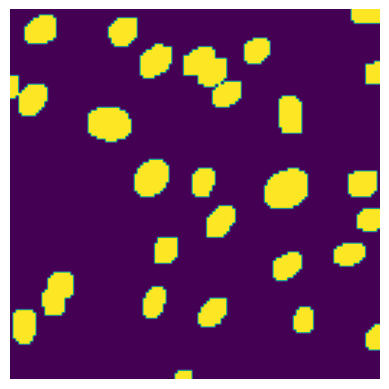

Validation Predicted Mask:


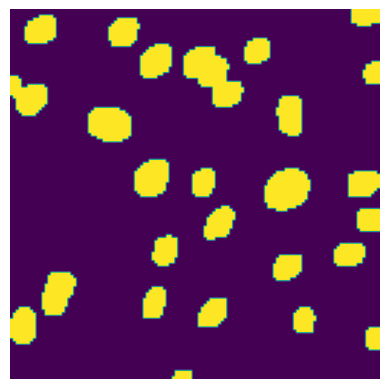

In [ ]:
ix = random.randint(0, len(preds_val_t))

val_data_start = int(X_train.shape[0] * 0.9)

print("Validation Input Image:")
display_images(X_train[val_data_start:][ix])

print("Validation Ground Truth Mask:")
display_images(np.squeeze(Y_train[val_data_start:][ix]))

print("Validation Predicted Mask:")
display_images(np.squeeze(preds_val_t[ix]))